mean(y) = 0.0487279843444227
[0]	validation_0-aucpr:0.18676
[1]	validation_0-aucpr:0.19590
[2]	validation_0-aucpr:0.20145
[3]	validation_0-aucpr:0.19364
[4]	validation_0-aucpr:0.19264
[5]	validation_0-aucpr:0.18373
[6]	validation_0-aucpr:0.20162
[7]	validation_0-aucpr:0.19495
[8]	validation_0-aucpr:0.20207
[9]	validation_0-aucpr:0.19668
[10]	validation_0-aucpr:0.19557
[11]	validation_0-aucpr:0.20134
[12]	validation_0-aucpr:0.20126
[13]	validation_0-aucpr:0.20082
[14]	validation_0-aucpr:0.19495
[15]	validation_0-aucpr:0.19679
[16]	validation_0-aucpr:0.19599
[17]	validation_0-aucpr:0.19413
[18]	validation_0-aucpr:0.19540
Fitting 3 folds for each of 243 candidates, totalling 729 fits
[22:41:56] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. 

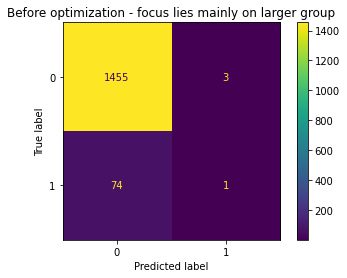

/home/sina/anaconda2/envs/trading/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


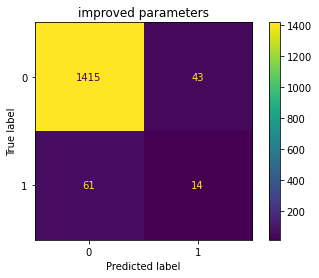

In [5]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb


"""
Predicting a future stroke
"""

# load data
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

# prepare data

#work type, gender
#different categories, nominal scale
df_1hots = pd.get_dummies(df, columns=['work_type', 'gender'])

#ever married
df_1hots.replace('Yes', True, inplace=True)
df_1hots.replace('No', False, inplace=True)
df_1hots['ever_married'] = df_1hots['ever_married'].astype('bool')
#Residence type
df_1hots['Residence_type'].replace('Urban', True, inplace=True)
df_1hots['Residence_type'].replace('Rural', False, inplace=True)
df_1hots.rename(columns = {'Residence_type':'Urban_residence'}, inplace=True)
#df_1hots.loc[(df_1hots['Residence_type']=='Urban'), 'Residence_type'] = 0
#df_1hots.loc[(df_1hots['Residence_type']=='Rural'), 'Residence_type'] = 1
#bmi, remove nans
df_1hots.loc[(np.isnan(df_1hots['bmi'])), 'bmi'] = 0
# smoking_status: ints instead of strings. I think introducing a hierarchy makes sense here
df_1hots.loc[(df_1hots['smoking_status']=='Unknown'), 'smoking_status'] = 0
df_1hots.loc[(df_1hots['smoking_status']=='never smoked'), 'smoking_status'] = 0
df_1hots.loc[(df_1hots['smoking_status']=='formerly smoked'), 'smoking_status'] = 1
df_1hots.loc[(df_1hots['smoking_status']=='smokes'), 'smoking_status'] = 2
df_1hots['smoking_status'] = df_1hots['smoking_status'].astype('int64')
#don't use .convert_dtypes! It converts into booeanDtype instead of bool, which is not usa
#df_1hots = df_1hots.convert_dtypes()

#test and training data
y = df_1hots['stroke'].copy()
X = df_1hots.drop(['id', 'stroke'], axis=1)
print('mean(y) = '+str(np.mean(y)))
# mean(y) = 0.04, extremely uneven
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=.3, random_state=42, stratify=y)

# before optimization
cl_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, use_label_encoder=False)
cl_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])
ConfusionMatrixDisplay.from_estimator(cl_xgb, X_test, y_test)
plt.title('Before optimization - focus lies mainly on larger group')
plt.show()

#optimize parameters using grid search cross validation
param_grid = {
    'max_depth': [3,4,5],
    'learn_rate': [.1, .05, .01],
    'gamma': [0, .25, 1.0],
    'reg_lambda': [0,1.0,10.0],
    'scale_pos_weight': [4,5,6]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=.9,
                                colsample_bytree=.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train,
           y_train,
           verbose=False,
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

print("best params: {'gamma': 1.0, 'learn_rate': 0.1, 'max_depth': 3, 'reg_lambda': 10.0, 'scale_pos_weight': 4}")
cl_xgb2 = xgb.XGBClassifier(seed=42,
                           objective='binary:logistic',
                           gamma=1.0,
                           learn_rate=.1,
                           max_depth=3,
                           reg_lambda=10.0,
                           scale_pos_weight=4,
                           subsample=.9,
                           colsample_bytree=.5)
cl_xgb2.fit(X_train,
           y_train,
           verbose=False,
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])


#plot_confusion_matrix # old command
ConfusionMatrixDisplay.from_estimator(cl_xgb2, X_test, y_test)
plt.title('improved parameters')
plt.show()

Initially the very imbalanced group sizes cause the model to prioritize the detection of correct rejections over hits.
Only 5% of subjects are stroke patients. Given this circumstance, a classifier like this one is not practically useful.
I tried adjusting the parameter scale_pos_weight, which can help prioritize accurate classification of the smaller group,
but wasn't sufficient in this case. Even with other parameters optimized further within a small range, the number hits
remained lower than the number of mistakes (false positives and false negatives), so that other strategies must be explored.

